/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-1-aa476ed77355>:123: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 138s 432ms/step - accuracy: 0.0175 - loss: 3.7339 - val_accuracy: 0.0262 - val_loss: 3.6371
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - accuracy: 0.0294 - loss: 3.6302 - val_accuracy: 0.0267 - val_loss: 3.5530
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.0295 - loss: 3.6710 - val_accuracy: 0.0381 - val_loss: 3.5072
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 241ms/step - accuracy: 0.0493 - loss: 3.5237 - val_accuracy: 0.1236 - val_loss: 3.2690
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 0.0847 - loss: 3.4521 - val_accuracy: 0.0947 - val_loss: 3.4233
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 237ms/step - accuracy: 0.0971 - loss: 3.3936 - val_accuracy: 0.1360 - val_loss: 3.1180
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 52s 245ms/step - accuracy: 0.1143 - loss: 3.2763 - val_accuracy: 0.1618 - val_loss: 3.0146
Epoch 8/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - accuracy: 0.1217 - loss: 3.1154 - va

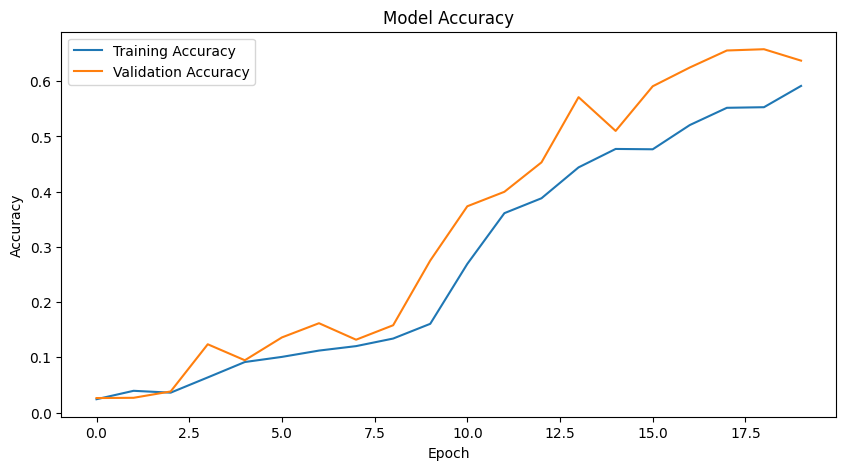

329/329 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step


ValueError: Found input variables with inconsistent numbers of samples: [10547, 10528]

<Figure size 1000x600 with 0 Axes>

In [1]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Layer, Dropout, LayerNormalization, MultiHeadAttention, Add, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import precision_recall_curve

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Patch extraction layer
class PatchExtractor(Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Position embedding layer
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# Transformer block
class TransformerBlock(Layer):
    def __init__(self, projection_dim, num_heads, dropout_rate):
        super().__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dense1 = Dense(2 * projection_dim, activation="gelu")
        self.dense2 = Dense(projection_dim)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.add = Add()

    def call(self, inputs):
        x1 = self.norm1(inputs)
        attention_output = self.attention(x1, x1)
        attention_output = self.dropout1(attention_output)
        x2 = self.add([attention_output, inputs])
        
        x3 = self.norm2(x2)
        x4 = self.dense1(x3)
        x4 = self.dense2(x4)
        x4 = self.dropout2(x4)
        return self.add([x2, x4])

# Create ViT model
def create_vit_model(
    input_shape,
    patch_size,
    num_classes,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    mlp_units,
    dropout_rate=0.1
):
    num_patches = (input_shape[0] // patch_size) ** 2
    
    inputs = Input(shape=input_shape)
    patches = PatchExtractor(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple transformer blocks
    x = encoded_patches
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(projection_dim, num_heads, dropout_rate)(x)

    # Create classification head
    representation = LayerNormalization(epsilon=1e-6)(x)
    representation = GlobalAveragePooling1D()(representation)
    representation = Dropout(dropout_rate)(representation)

    # MLP head
    features = Dense(mlp_units[0], activation="gelu")(representation)
    features = Dropout(dropout_rate)(features)
    features = Dense(mlp_units[1], activation="gelu")(features)
    features = Dropout(dropout_rate)(features)
    outputs = Dense(num_classes, activation="softmax")(features)

    return Model(inputs=inputs, outputs=outputs)

# Data augmentation
train_augmentation = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

# Dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load and prepare data
def load_data(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image / 255.0

# Load dataset
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Load training data
train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split data
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Load test data
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Create data generators
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_images = np.array([load_data(path) for path in batch_paths])
        if self.augment:
            batch_images = np.array([
                train_augmentation(image=img)["image"] 
                for img in batch_images
            ])
        
        return batch_images, np.array(batch_labels)

# Create data generators
train_generator = CustomDataGenerator(train_imgs, train_labels, augment=True)
val_generator = CustomDataGenerator(val_imgs, val_labels, augment=False)
test_generator = CustomDataGenerator(test_imgs, test_labels, augment=False)

# Model parameters
input_shape = (224, 224, 3)
patch_size = 16
num_classes = 38
projection_dim = 64
num_heads = 8
num_transformer_blocks = 8
mlp_units = [2048, 1024]
dropout_rate = 0.1

# Create and compile model
model = create_vit_model(
    input_shape,
    patch_size,
    num_classes,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    mlp_units,
    dropout_rate
)

# Compute class weights
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(all_labels),
    y=all_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Compile model
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute predictions for PR curve
test_predictions = model.predict(test_generator)
y_true = tf.keras.utils.to_categorical(test_labels, num_classes)

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], test_predictions[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming we have test_predictions and test_labels from the model
test_predictions = model.predict(test_generator)
y_true = tf.keras.utils.to_categorical(test_labels, num_classes)

# Create figure
plt.figure(figsize=(15, 10))

# Plot PR curve for each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], test_predictions[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

# Customize the plot
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for Each Disease Class', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,
          fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot if needed
# plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')

plt.show()

329/329 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step


ValueError: Found input variables with inconsistent numbers of samples: [10547, 10528]

<Figure size 1500x1000 with 0 Axes>

In [1]:
# ... (previous code remains the same until the evaluation part)

# Modify the PR curve visualization section
def plot_pr_curves(model, test_generator, test_labels, num_classes, top_k=5):
    """
    Plot precision-recall curves for the top k classes with highest AUC-PR scores
    
    Args:
        model: Trained model
        test_generator: Test data generator
        test_labels: True labels
        num_classes: Total number of classes
        top_k: Number of top classes to plot
    """
    # Compute predictions
    test_predictions = model.predict(test_generator, verbose=1)
    y_true = tf.keras.utils.to_categorical(test_labels, num_classes)
    
    # Calculate AUC-PR for each class
    from sklearn.metrics import average_precision_score
    ap_scores = []
    for i in range(num_classes):
        ap = average_precision_score(y_true[:, i], test_predictions[:, i])
        ap_scores.append((i, ap))
    
    # Sort classes by AP score and get top k
    top_classes = sorted(ap_scores, key=lambda x: x[1], reverse=True)[:top_k]
    
    # Create PR curves plot
    plt.figure(figsize=(12, 8))
    
    # Color map for better visualization
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))
    
    # Plot PR curve for each top class
    for idx, (class_idx, ap_score) in enumerate(top_classes):
        precision, recall, _ = precision_recall_curve(
            y_true[:, class_idx], 
            test_predictions[:, class_idx]
        )
        plt.plot(
            recall, precision, 
            color=colors[idx],
            label=f'Class {class_idx} (AP={ap_score:.3f})',
            linewidth=2
        )
    
    # Customize plot
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves for Top 5 Classes', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add baseline
    plt.axhline(y=1/num_classes, color='r', linestyle='--', alpha=0.3, 
                label='Random Baseline')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nAverage Precision Scores for Top Classes:")
    for class_idx, ap_score in top_classes:
        print(f"Class {class_idx}: {ap_score:.3f}")
    
    return ap_scores

# After model training, call the new function
ap_scores = plot_pr_curves(
    model=model,
    test_generator=test_generator,
    test_labels=test_labels,
    num_classes=num_classes,
    top_k=5
)

NameError: name 'model' is not defined